Price, Macro, Time Series Script

In [2]:
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from ipywidgets import HBox, VBox
import scipy.stats as sps
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf
import bs4 as bs
import requests
import yfinance as yf
import datetime
from scipy.stats import gamma
from scipy.stats import beta
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import datetime as dt
import sqlite3
import time
import config 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import ndtest        
from financetoolkit import Toolkit
from hurst import compute_Hc
import warnings
warnings.filterwarnings("ignore")


class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = 'THREEFF2','THREEFF10','DGS5', 'DGS10','DGS2','NASDAQCOM'
    
    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        
            final = pd.concat(symbols)
            final_df = final.reset_index()
        
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()

        self.interval = '1d'
        self.ticker_list = ["SPY",'BA','HII','RTX','CW','TXT','MOG-A','KAMN','NPK','TDG','TGI','HXL',
           'AXON','GD','BWXT','WWD','LHX','MRCY','LMT','AIR','AVAV','NOC','SWBI',
           'RGR','HEI','^TNX'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]
    
class Strategy:
    def __init_(self):
         self.start_date = '2000-01-01'   
    
    def fundamentals(self, ticker, base_url, data_type, API_KEY):   
        url = f'{base_url}/v3/{data_type}/{ticker}?period=quarter&limit=400&apikey={API_KEY}'
        response = requests.get(url)
        data = response.json()
        return pd.DataFrame(data)

    def fundamental_data(self, base_url, tickers):
        try:
            dataframe = []
            for ticker in tickers:
                data_type = ['income-statement','balance-sheet-statement','cash-flow-statement']
                inc = self.fundamentals(ticker, base_url, data_type[0], API_KEY)
                inc = inc.set_index('date')
                bs = self.fundamentals(ticker, base_url, data_type[1], API_KEY)
                bs = bs.set_index('date')
                bs = bs.add_suffix('_bs')
                cf = self.fundamentals(ticker, base_url, data_type[2], API_KEY)
                cf = cf.set_index('date')
                cf = cf.add_suffix('_cf')
                df = pd.concat([inc, bs, cf],axis=1)

                df['workingCapRatio'] = (df['totalCurrentAssets_bs'] - df['totalCurrentLiabilities_bs']) / df['totalAssets_bs']
                df['reinvestToAssets'] = df['retainedEarnings_bs'] / df['totalAssets_bs']
                df['operatingEarningsToAssets'] = (df['ebitda'] - df['depreciationAndAmortization']) / df['totalAssets_bs']
                df['leverage'] = df['totalEquity_bs'] / df['totalLiabilities_bs']
                df['assetTurnover'] = df['revenue'] / df['totalAssets_bs']
                df['Altman Z-Score'] = 1.2 * df['workingCapRatio'] + 1.4 * df['reinvestToAssets'] + 3.3 * df['operatingEarningsToAssets'] + 0.6 * df['leverage'] + 1.0 * df['assetTurnover']

                df = df.reset_index().set_index('fillingDate')
                # df.index = pd.to_datetime(df.index)
                dataframe.append(df)
        except:
            pass
        return pd.concat(dataframe)

    def factor_signal_generation(self,fund_final1, target_metric):
        final_fund_data = []
        for company1 in fund_final1.symbol.unique():
            df12 = fund_final1.loc[fund_final1.symbol == company1]
            df12 = df12.set_index('fillingDate')
            df12['target_growth_metric'] = 100 * (df12[target_metric]/df12[target_metric].shift(4)-1)
            df12 = df12.pivot_table(index = 'fillingDate',columns='symbol',values='target_growth_metric')
            final_fund_data.append(df12)
        final_fund_data1 = pd.concat(final_fund_data).sort_index().fillna(method='ffill')
        start = '2009'
        end = '2023-10-30'
        final_fund_data1 = final_fund_data1.loc[start:end]
        final_fund_data1 = final_fund_data1.dropna(axis=1).dropna()
        final_fund_data1.index = pd.to_datetime(final_fund_data1.index)
        final_fund_data1.replace([np.inf, -np.inf], 0, inplace=True)
        return final_fund_data1

    def fundamental_momentum(self,prices, fundamental_data, hold_days, take_amount,take_amount1, short_bool):
        hold_returns = prices.pct_change(hold_days).shift(-hold_days)
        fundamental_rank = fundamental_data.rank(axis=1)
        n = len(fundamental_rank.columns)
        def signal(rank):

            # signal = np.where(rank > n*9/10, 1, np.nan)
            # signal = np.where(rank < n*1/10, -1, signal)

            signal = np.where(rank > n*take_amount, 1, np.nan)
            signal = np.where(rank < n*take_amount1, short_bool, signal)
            return signal
        trading_signal = fundamental_rank.apply(signal, axis=0)
        return hold_returns, trading_signal


    def calculate_performance(self,hold_returns, trading_signal, hold_days):
        stocks_returns = hold_returns * trading_signal
        stocks_returns = stocks_returns[::hold_days]
        trading_signal = trading_signal[::hold_days]
        trading_signal = trading_signal.replace(np.nan, 0)
        cost = (0.001 * np.abs(trading_signal - trading_signal.shift(1)))
        stocks_returns = stocks_returns - cost
        ### portfolio returns of holdings after accounting for TC and slippage (approximation)
        portfolio_returns = stocks_returns.mean(axis=1)
        cum_rets = (portfolio_returns+1).cumprod().dropna()
        total_portfolio_returns = (cum_rets.iloc[-1]-1)*100
        print("Portfolio Returns: %.2f" % total_portfolio_returns)
        ### sharpe ratio
        sharpe = np.mean(portfolio_returns) / np.std(portfolio_returns)*((252/hold_days)**0.5)
        print('Sharpe Ratio: %.2f' % sharpe)
        fig = plt.figure(figsize=(16, 7))
        sub = fig.add_subplot(1, 2, 1)
        cum_rets.plot()
        sub.set_ylabel('Strategy Returns', fontsize=12)
        sub.set_xlabel('Date', fontsize=12)
        running_max = np.maximum.accumulate(cum_rets.dropna())
        running_max[running_max < 1] = 1
        drawdown = ((cum_rets)/running_max - 1)
        sub = fig.add_subplot(1, 2, 2)
        drawdown.plot(color='b')
        plt.fill_between(drawdown.index, drawdown.values, color='blue')
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.4)
        sub.set_ylabel('Returns', fontsize=12)
        plt.show()
        return portfolio_returns, cum_rets

Fundamental Data

In [3]:
strat = Strategy()

In [4]:
tickers = ['BA','HII','RTX','CW','TXT','MOG-A','KAMN','NPK','TDG','TGI','HXL',
           'AXON','GD','BWXT','WWD','LHX','MRCY','LMT','AIR','AVAV','NOC','SWBI',
           'RGR','HEI']

base_url = 'https://financialmodelingprep.com/api'

fund = strat.fundamental_data(base_url, tickers)
main1 = fund.dropna().sort_index()
comps = main1.symbol.unique()
main = Trading(0, "2018-01-01", "2020-01-01")         # set first input to one if you want exact date inputs
df, df1, df2 = main.yahoo_universe()                  # dont have to run this everytime
main.trading_sql(df)                                  # placing the data into my sql datatable => consensusinvestable

Updating the sql table was a success


In [5]:
pd.set_option('display.max_columns',None)   # dislay all columns so we can see better
df1 = df.pivot_table(columns = 'ticker',values = 'Adj Close',index = 'Date').drop(['^TNX','SPY'],axis=1)['2012':]  # drop benchmark and risk free rate
df1.index = pd.to_datetime(df1.index, format='%Y-%m-%d')                                                           # change to datetime 
df_change = df1.pct_change().shift(-1)      # shift a day back to get that return for the day that we actually made the trade
df_change = df_change.dropna()              # Drop the rows containing the null values
df_change

ticker,AIR,AVAV,AXON,BA,BWXT,CW,GD,HEI,HII,HXL,KAMN,LHX,LMT,MOG-A,MRCY,NOC,NPK,RGR,RTX,SWBI,TDG,TGI,TXT,WWD
Date,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-03,-0.003039,-0.007246,-0.028302,0.001482,0.014837,0.005860,0.001765,-0.020916,-0.017912,0.002862,-0.038613,-0.004364,-0.013533,-0.034344,-0.004380,-0.000512,-0.003693,-0.018746,0.005224,0.011136,-0.010098,0.011951,0.019850,0.006432
2012-01-04,-0.003557,-0.038155,0.000000,-0.010763,0.001253,-0.002496,-0.010569,-0.003355,0.003145,0.013861,-0.003347,0.004657,-0.010382,-0.002771,-0.006598,-0.008187,0.000847,0.062090,-0.009594,0.039647,0.022120,0.016534,0.005260,0.009468
2012-01-05,0.003060,0.033115,-0.005825,0.006120,-0.022111,0.012514,0.003264,-0.008503,0.012539,-0.003619,0.035448,0.013631,-0.001124,-0.009958,0.026568,-0.004299,-0.001587,0.000281,-0.005785,-0.008474,0.016283,0.012282,0.000523,-0.001641
2012-01-06,0.005592,0.009349,0.005859,0.007434,0.002133,0.015105,0.011092,-0.000536,-0.013622,0.011703,0.021261,0.007531,0.000750,-0.007485,-0.003595,0.000173,-0.000424,0.019668,0.002706,0.017094,0.007339,0.003607,-0.002615,0.012681
2012-01-09,0.023762,0.006616,0.011650,0.006306,0.015751,0.009199,0.022817,0.008938,0.024482,0.035501,0.039167,0.011746,0.007247,0.010134,-0.018038,0.012260,0.007953,-0.026454,0.026046,-0.018908,0.012827,0.006371,0.057682,0.020177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16,0.005113,-0.009978,0.003232,0.006970,0.004285,-0.003223,-0.002324,0.000000,0.009294,0.003039,0.002950,-0.003060,-0.002042,0.002025,-0.004380,0.000625,-0.012609,-0.001342,-0.006855,0.003587,0.005967,0.012218,0.007944,-0.019055
2023-11-17,-0.000598,0.026476,0.012261,0.046482,0.014654,0.006324,0.004455,0.004001,0.011869,0.014087,0.007843,0.004254,-0.001956,0.011901,0.002346,0.003555,-0.013408,0.009183,-0.006401,0.001430,0.007028,0.005571,0.007494,-0.002600
2023-11-20,0.009581,0.003818,0.009725,0.002572,-0.004857,0.003689,0.002563,0.004161,-0.001169,-0.004481,-0.011673,0.011154,0.009779,0.007041,0.005851,0.011270,0.008413,0.009765,-0.012884,-0.004283,0.006917,0.000923,-0.002565,0.007898


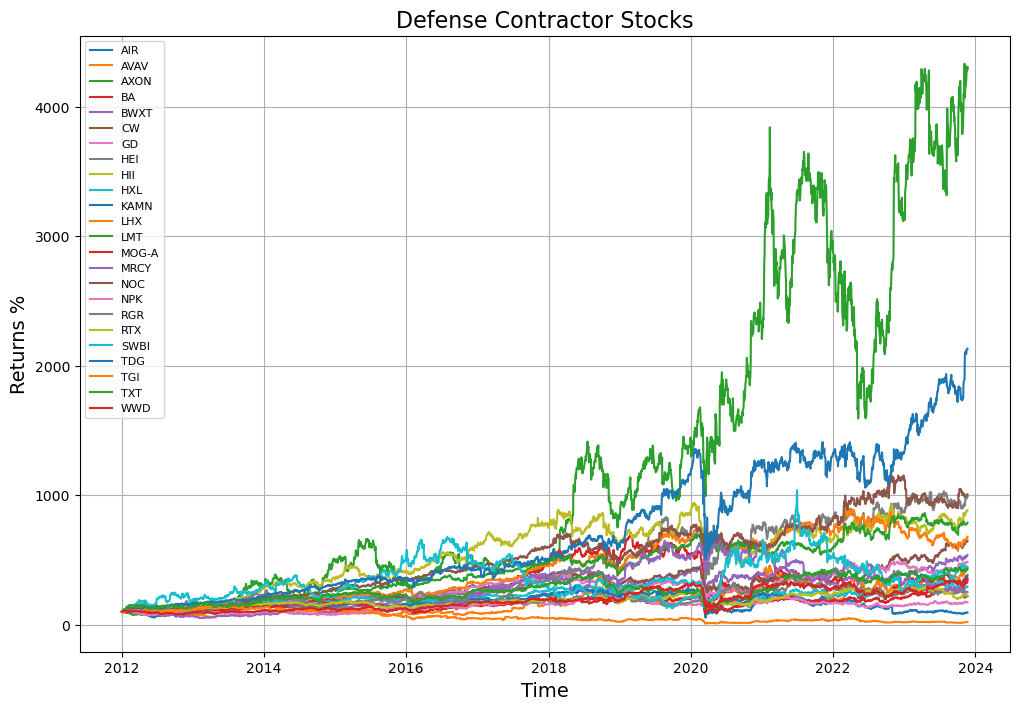

In [6]:
# Plot the percentage returns of  the stocks
plt.figure(figsize=(12, 8))
for column in df_change.columns.values:
    plt.plot(df_change.index, (df_change + 1).cumprod()[column] * 100,
             label=column)
plt.legend(loc='upper left', fontsize=8)
plt.ylabel('Returns %',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title('Defense Contractor Stocks',fontsize=16)
plt.grid()
plt.show()

Momentum Factor

,Momentum Factor
Date,
2023-11-16,0.001690
2023-11-17,-0.000691
2023-11-20,-0.001239
2023-11-21,0.002528
2023-11-22,0.002024


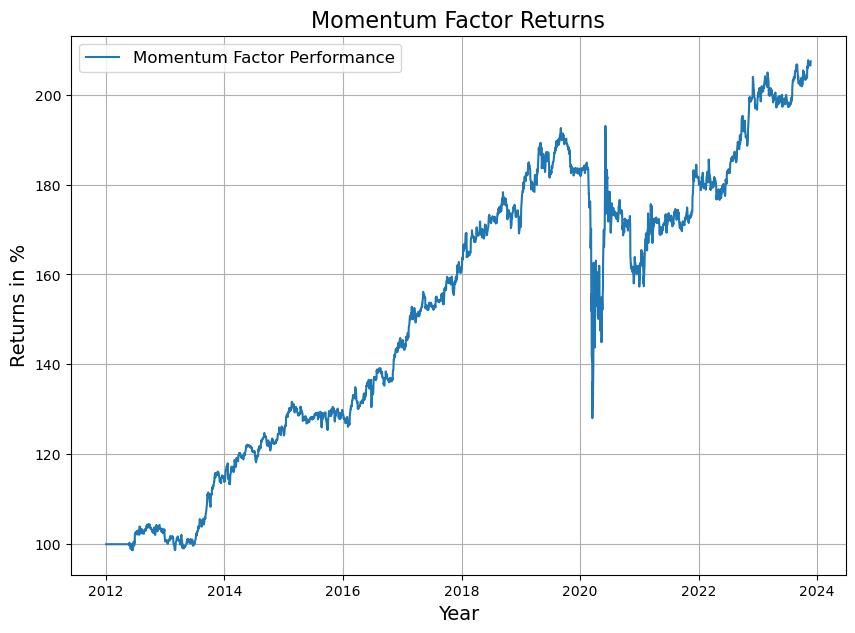

In [7]:
H = lambda x: compute_Hc(x)[0]
window = 100
mf = df1.rolling(window).apply(H)
# mf = df1 - df1.rolling(21*11).mean()    # difference between current price and the mean of the price one year ago
ml = mf[mf > .550]                        # buy when there's momentum
ms = mf[mf < .450]                        # short when theres no momentum
mom_perf = (df_change * ~ml.isnull() - df_change* ~ms.isnull()).mean(axis=1)                  # difference between positive momentum and negative momentum
mom_perf = pd.DataFrame(mom_perf.dropna(), columns=['Momentum Factor'])                       # changing to a dataframe 
mom_perf.index = pd.to_datetime(mom_perf.index, format='%Y-%m-%d')                            # changing to datetime index
display(mom_perf.tail())
plt.figure(figsize=(10, 7))
plt.plot((mom_perf + 1).cumprod()* 100, label='Momentum Factor Performance')
plt.legend(loc='best', fontsize=12)
plt.title('Momentum Factor Returns', fontsize=16)
plt.ylabel('Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

FCF Yield Factor

In [8]:
shares = fund.pivot_table(columns = 'symbol', index = 'fillingDate', values = 'weightedAverageShsOutDil')   # pivot table to get only symbols and Altman Z Score
shares.index = pd.to_datetime(shares.index)
shares = shares.fillna(method='ffill')
mkt_cap = (shares['2012':])*(df1)
mkt_cap = mkt_cap.fillna(method='ffill') 
z = fund.pivot_table(columns = 'symbol', index = 'fillingDate', values = 'freeCashFlow_cf')   # pivot table to get only symbols and Altman Z Score
z.index = pd.to_datetime(z.index)
z = z.fillna(method='ffill') 
fcf_yield = (z['2012':])/(mkt_cap)
fcf_yield = fcf_yield.dropna()
fcf_yield_rank = fcf_yield.rank(axis=1)
fcf_yield_rank

symbol,AIR,AVAV,AXON,BA,BWXT,CW,GD,HEI,HII,HXL,KAMN,LHX,LMT,MOG-A,MRCY,NOC,NPK,RGR,RTX,SWBI,TDG,TGI,TXT,WWD
2012-01-24,17.0,10.0,14.0,7.0,3.0,11.0,5.0,16.0,24.0,6.0,8.0,4.0,13.0,18.0,9.0,23.0,15.0,12.0,21.0,20.0,19.0,1.0,22.0,2.0
2012-02-01,16.0,9.0,14.0,6.0,3.0,10.0,4.0,13.0,24.0,5.0,7.0,19.0,12.0,17.0,8.0,23.0,15.0,11.0,22.0,21.0,18.0,1.0,20.0,2.0
2012-02-03,16.0,8.0,13.0,5.0,2.0,9.0,3.0,12.0,24.0,4.0,6.0,19.0,11.0,17.0,7.0,23.0,14.0,10.0,22.0,21.0,18.0,15.0,20.0,1.0
2012-02-07,17.0,9.0,14.0,5.0,2.0,10.0,4.0,13.0,24.0,3.0,6.0,19.0,12.0,7.0,8.0,23.0,15.0,11.0,22.0,21.0,18.0,16.0,20.0,1.0
2012-02-08,16.0,8.0,13.0,5.0,2.0,9.0,4.0,12.0,24.0,3.0,6.0,20.0,11.0,7.0,17.0,23.0,14.0,10.0,22.0,21.0,18.0,15.0,19.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-02,3.0,5.0,9.0,7.0,11.0,21.0,20.0,10.0,24.0,14.0,12.0,15.0,23.0,6.0,8.0,17.0,4.0,2.0,22.0,18.0,13.0,1.0,16.0,19.0
2023-11-07,4.0,6.0,9.0,8.0,11.0,21.0,20.0,10.0,24.0,14.0,12.0,15.0,23.0,7.0,2.0,17.0,5.0,3.0,22.0,19.0,13.0,1.0,16.0,18.0
2023-11-13,4.0,6.0,9.0,8.0,11.0,21.0,20.0,10.0,24.0,14.0,13.0,15.0,23.0,7.0,2.0,17.0,5.0,3.0,22.0,19.0,12.0,1.0,16.0,18.0
2023-11-14,4.0,6.0,8.0,7.0,10.0,20.0,19.0,9.0,24.0,13.0,11.0,14.0,22.0,23.0,2.0,16.0,5.0,3.0,21.0,18.0,12.0,1.0,15.0,17.0


,FCF Yield Factor
2012-01-24,0.005166
2012-02-01,0.001237
2012-02-03,-0.002126
2012-02-07,0.002797
2012-02-08,-0.000172
...,...
2023-11-02,-0.008908
2023-11-07,-0.000774
2023-11-13,-0.005399
2023-11-14,0.000344


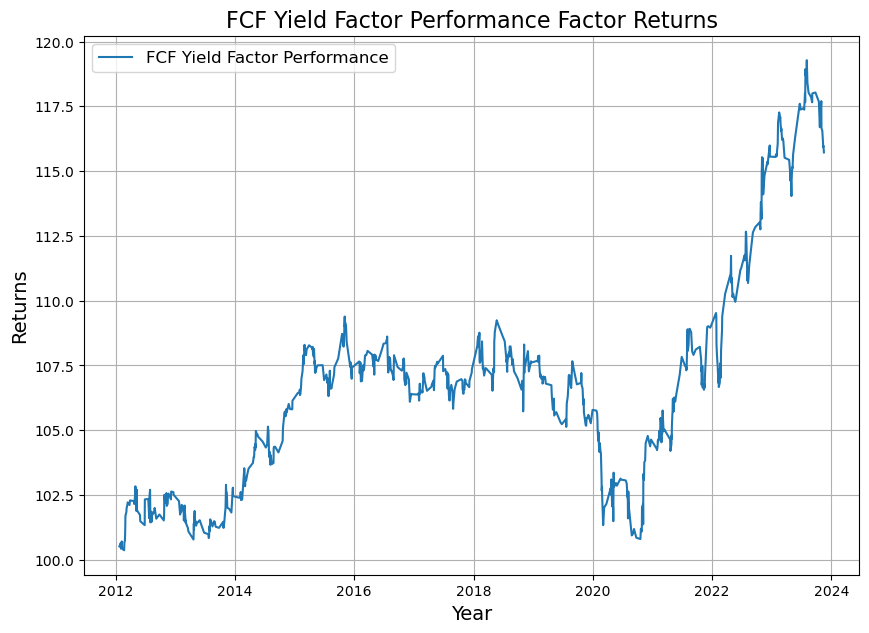

In [9]:
fcf_yield_s = fcf_yield_rank[fcf_yield_rank < int(len(fcf_yield_rank.columns)*.4)]              # short when the fcf yield is in the 40th percentile or below
fcf_yield_l = fcf_yield_rank[fcf_yield_rank > int(len(fcf_yield_rank.columns)*.6)]              # long when the fcf yield is in the 60th percentile or higher
fcf_perf = (df_change * ~fcf_yield_l.isnull() - df_change* ~fcf_yield_s.isnull()).mean(axis=1)  # high fcf yield vs short fcf yield
fcf_perf = pd.DataFrame(fcf_perf.dropna(), columns=['FCF Yield Factor'])                        # creating a dataframe
fcf_perf.index = pd.to_datetime(fcf_perf.index, format='%Y-%m-%d')                              # changing to datetime index
display(fcf_perf)
plt.figure(figsize=(10, 7))
plt.plot((fcf_perf + 1).cumprod()* 100, label='FCF Yield Factor Performance')
plt.legend(loc='best', fontsize=12)
plt.title('FCF Yield Factor Performance Factor Returns', fontsize=16)
plt.ylabel('Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

,Altman Z-Score Factor
2012-01-24,-0.011724
2012-02-01,0.000898
2012-02-03,-0.003710
2012-02-07,0.003759
2012-02-08,-0.001867
...,...
2023-11-02,0.005537
2023-11-07,-0.007050
2023-11-13,0.012814
2023-11-14,-0.002113


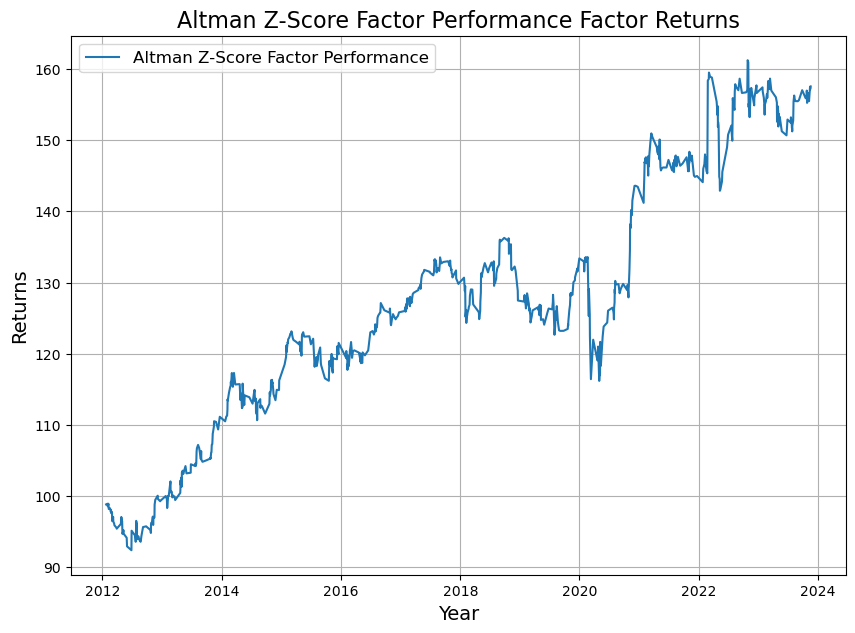

In [10]:
alt = fund.pivot_table(columns = 'symbol', index = 'fillingDate', values = 'Altman Z-Score')   # pivot table to get only symbols and Altman Z Score
alt.index = pd.to_datetime(alt.index)
alt = alt.fillna(method='ffill') 
alt = alt.dropna()
alt_s = alt[alt < 1.00]              # short when the Z-Score is below 1
alt_l = alt[alt > 1.00]              # long when the Z-Score is above 1
alt_perf = (df_change * ~alt_l.isnull() - df_change* ~alt_s.isnull()).mean(axis=1)              # high fcf yield vs short fcf yield
alt_perf = pd.DataFrame(alt_perf.dropna(), columns=['Altman Z-Score Factor'])             # creating a dataframe
alt_perf.index = pd.to_datetime(alt_perf.index, format='%Y-%m-%d')                              # changing to datetime index
display(alt_perf)
plt.figure(figsize=(10, 7))
plt.plot((alt_perf + 1).cumprod()* 100, label='Altman Z-Score Factor Performance')
plt.legend(loc='best', fontsize=12)
plt.title('Altman Z-Score Factor Performance Factor Returns', fontsize=16)
plt.ylabel('Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

In [11]:
total = pd.concat([fcf_perf, mom_perf,alt_perf],axis=1).fillna(0)
total = total['2013':]

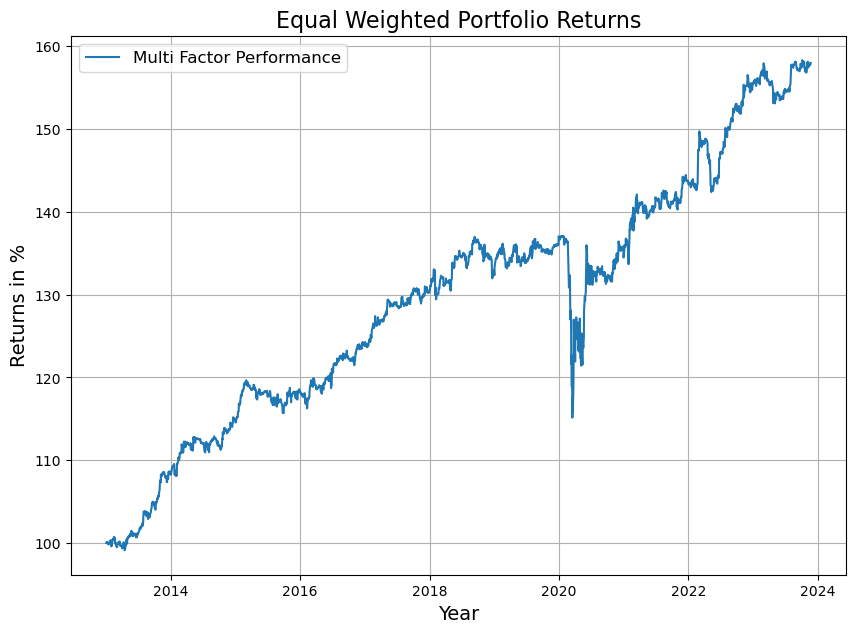

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(total.index.date, 
         ((total['Momentum Factor'].values + total['FCF Yield Factor'].values + total['Altman Z-Score Factor'].values) / 3 \
          + 1).cumprod() * 100, label='Multi Factor Performance')
plt.title('Equal Weighted Portfolio Returns', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.ylabel('Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

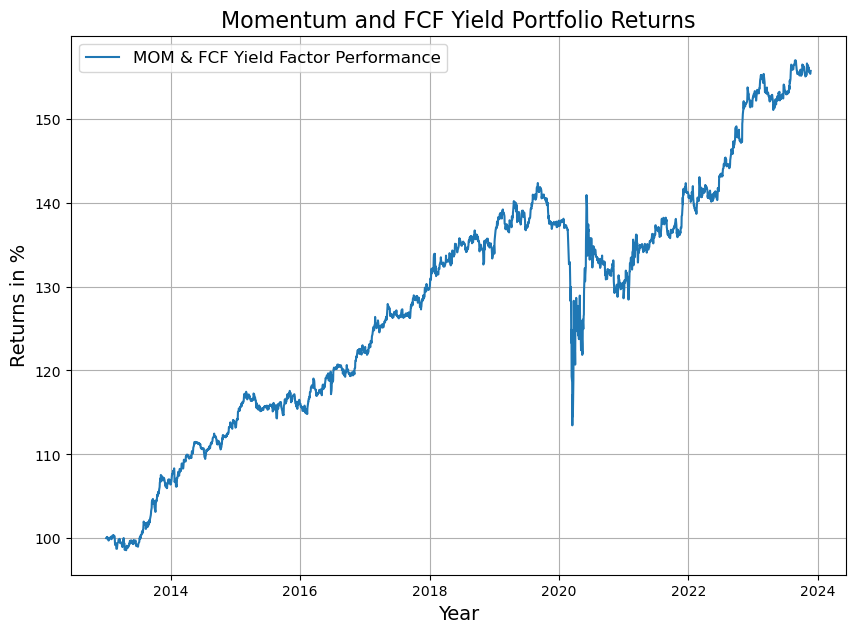

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(total.index.date, 
         ((total['Momentum Factor'].values + total['FCF Yield Factor'].values) / 2+ 1).cumprod() * 100, label='MOM & FCF Yield Factor Performance')
plt.title('Momentum and FCF Yield Portfolio Returns', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.ylabel('Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

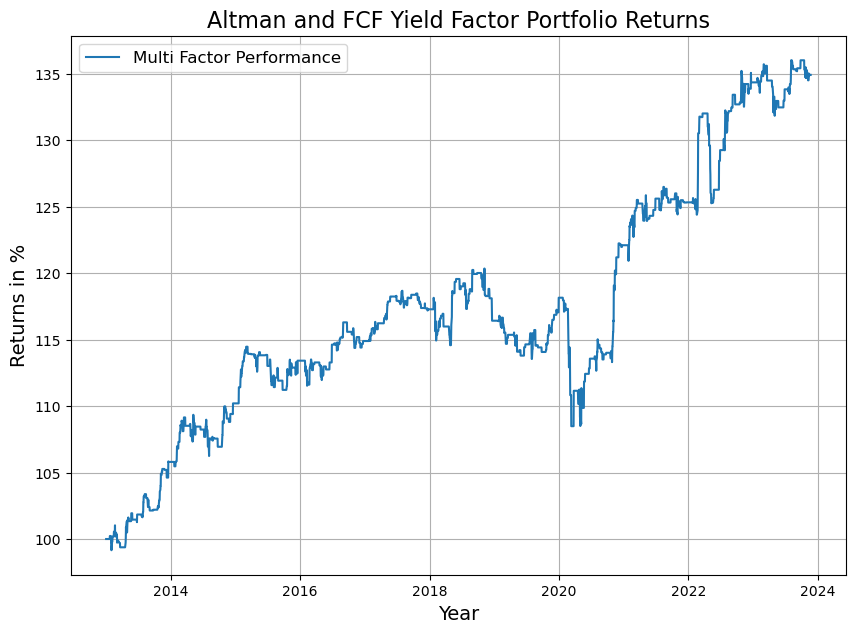

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(total.index.date, 
         ((total['Altman Z-Score Factor'].values + total['FCF Yield Factor'].values) / 2+ 1).cumprod() * 100, label='Multi Factor Performance')
plt.title('Altman and FCF Yield Factor Portfolio Returns', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.ylabel('Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

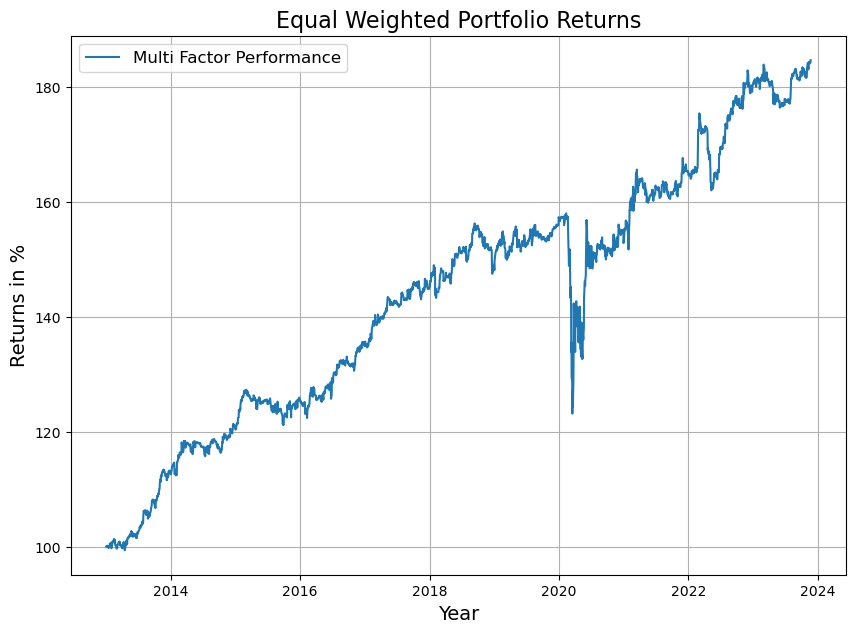

In [15]:
plt.figure(figsize=(10, 7))
plt.plot(total.index.date, 
         ((total['Altman Z-Score Factor'].values + total['Momentum Factor'].values) / 2+ 1).cumprod() * 100, label='Multi Factor Performance')
plt.title('Equal Weighted Portfolio Returns', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.ylabel('Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

In [16]:
pd.concat([((total[['Momentum Factor']] + 1).cumprod() * 100),((total[['Altman Z-Score Factor']] + 1).cumprod() * 100),((total[['FCF Yield Factor']] + 1).cumprod() * 100)],axis=1).corr()

,Momentum Factor,Altman Z-Score Factor,FCF Yield Factor
Momentum Factor,1.000000,0.853598,0.652197
Altman Z-Score Factor,0.853598,1.000000,0.756716
FCF Yield Factor,0.652197,0.756716,1.000000


In [17]:
print('Correlation Coeff for Momentum (Hurst Exponent) and FCF Yield:', ((total['Momentum Factor']
                                                  + 1).cumprod() * 100).corr((total['FCF Yield Factor']
                                                                              + 1).cumprod() * 100))

Correlation Coeff for Momentum (Hurst Exponent) and FCF Yield: 0.6521969461017127


In [18]:
print('Correlation Coeff for the two factors:', ((total['Momentum Factor']
                                                  + 1).cumprod() * 100).corr((total['Altman Z-Score Factor']
                                                                              + 1).cumprod() * 100))

Correlation Coeff for the two factors: 0.8535983638152694


In [19]:
print('Correlation Coeff for the two factors:', ((total['FCF Yield Factor']
                                                  + 1).cumprod() * 100).corr((total['Altman Z-Score Factor']
                                                                              + 1).cumprod() * 100))

Correlation Coeff for the two factors: 0.7567163894336052


In [20]:
# total['BM'] = (df_change * ~df1.isnull()).mean(axis=1)
total['FCF Yield & Momentum'] = total['FCF Yield Factor'] + total['Momentum Factor'] / 2
total['FCF Yield & Altman Z'] = total['Altman Z-Score Factor'] + total['FCF Yield Factor'] / 2
total['Altman Z-Score & Momentum'] = total['Altman Z-Score Factor'] + total['Momentum Factor'] / 2
total['FCF Yield & Altman Z & Momentum'] = total['Altman Z-Score Factor'] + total['FCF Yield Factor'] + total['Momentum Factor'] / 3

In [21]:
bench = df_change.mean(axis=1)
bm = pd.DataFrame(bench, columns=['BM'])
total['bm'] = bench

Annualized Returns

In [22]:
risk_free_rate = 0.02
trading_days = 252
average_daily_returns = total.mean()
annual_returns = ((1 + average_daily_returns)**(trading_days) - 1)*100
annual_returns

FCF Yield Factor                    1.166595
Momentum Factor                     7.639425
Altman Z-Score Factor               4.628561
FCF Yield & Momentum                4.959861
FCF Yield & Altman Z                5.236984
Altman Z-Score & Momentum           8.551101
FCF Yield & Altman Z & Momentum     8.478141
bm                                 20.040547
dtype: float64

Annualiszed Volatiltity

In [23]:
daily_std_dev = total.std()
annual_volatility = daily_std_dev * np.sqrt(trading_days) * 100
annual_volatility

FCF Yield Factor                    3.041190
Momentum Factor                    11.971354
Altman Z-Score Factor               7.562776
FCF Yield & Momentum                6.809236
FCF Yield & Altman Z                7.941928
Altman Z-Score & Momentum          10.743143
FCF Yield & Altman Z & Momentum    10.260969
bm                                 21.936848
dtype: float64

Sharpe Ratio

In [24]:
daily_risk_free_return = risk_free_rate/trading_days
excess_daily_returns = total - 0.00
sharpe_ratio = (excess_daily_returns.mean() /
                excess_daily_returns.std()) * np.sqrt(trading_days)
sharpe_ratio

FCF Yield Factor                   0.381387
Momentum Factor                    0.615031
Altman Z-Score Factor              0.598331
FCF Yield & Momentum               0.710982
FCF Yield & Altman Z               0.642788
Altman Z-Score & Momentum          0.763875
FCF Yield & Altman Z & Momentum    0.793216
bm                                 0.832962
dtype: float64

Sortino Ratio

In [25]:
net_returns = total - average_daily_returns
negative_returns = net_returns[net_returns < 0]
semi_dev = np.sqrt(np.sum((negative_returns**2))/len(total))
sortino_ratio = (excess_daily_returns.mean()/semi_dev) * np.sqrt(trading_days)
sortino_ratio

FCF Yield Factor                   0.574952
Momentum Factor                    0.882882
Altman Z-Score Factor              0.873114
FCF Yield & Momentum               1.045398
FCF Yield & Altman Z               0.951660
Altman Z-Score & Momentum          1.095862
FCF Yield & Altman Z & Momentum    1.161480
bm                                 1.152265
dtype: float64

In [26]:
bm = df.pivot_table(columns = 'ticker',values = 'Adj Close',index = 'Date')[['SPY']].pct_change().shift(-1)
bm.index = pd.to_datetime(bm.index)
total['SPY'] = bm
for i in total.columns:
    covariance_matrix = total[['SPY', i]].cov()
    covariance_value = covariance_matrix.iloc[0][i]
    market_variance = total['SPY'].var()
    beta = covariance_value/market_variance
    print(f'Beta {i}: {round(beta,2)}')

Beta FCF Yield Factor: 0.01
Beta Momentum Factor: 0.34
Beta Altman Z-Score Factor: 0.16
Beta FCF Yield & Momentum: 0.18
Beta FCF Yield & Altman Z: 0.17
Beta Altman Z-Score & Momentum: 0.33
Beta FCF Yield & Altman Z & Momentum: 0.29
Beta bm: 1.02
Beta SPY: SPY    1.0
SPY    1.0
Name: SPY, dtype: float64


In [27]:
portfolio_monthly_mean = total.resample('M').mean()
portfolio_monthly_count = total.resample('M').count()
portfolio_monthly_ret = (portfolio_monthly_mean +
                         1)**(portfolio_monthly_count) - 1
target = 0.00
display(portfolio_monthly_ret)
portfolio_monthly_ret[portfolio_monthly_ret >= target] = 1
portfolio_monthly_ret[portfolio_monthly_ret < target] = 0
display(round(portfolio_monthly_ret.mean(),2).sort_values())

,FCF Yield Factor,Momentum Factor,Altman Z-Score Factor,FCF Yield & Momentum,FCF Yield & Altman Z,Altman Z-Score & Momentum,FCF Yield & Altman Z & Momentum,bm,SPY
2013-01-31,-0.007432,0.011892,0.002429,-0.001545,-0.001302,0.008372,-0.001090,-0.006685,0.035623
2013-02-28,0.001648,-0.028024,0.010466,-0.012480,0.011298,-0.003780,0.002597,0.006800,0.006354
2013-03-31,-0.008026,0.020212,-0.011163,0.001955,-0.015141,-0.001212,-0.012531,0.019746,0.030705
2013-04-30,0.003889,-0.014325,0.018852,-0.003325,0.020829,0.011535,0.017909,-0.000272,0.015173
2013-05-31,0.000444,0.012681,0.018961,0.006769,0.019188,0.025397,0.023702,0.097216,0.038786
...,...,...,...,...,...,...,...,...,...
2023-07-31,0.011211,0.006892,-0.005426,0.014688,0.000135,-0.002004,0.008031,0.007219,0.028851
2023-08-31,-0.006936,0.034519,0.022534,0.010070,0.018985,0.040022,0.026998,0.000095,-0.010934
2023-09-30,0.001491,-0.023044,0.010021,-0.010111,0.010774,-0.001675,0.003704,-0.054261,-0.049163
2023-10-31,-0.008187,0.009909,-0.011253,-0.003283,-0.015310,-0.006363,-0.016120,0.039879,-0.010010


FCF Yield Factor                   0.52
FCF Yield & Altman Z               0.54
Altman Z-Score Factor              0.56
FCF Yield & Momentum               0.56
Altman Z-Score & Momentum          0.56
FCF Yield & Altman Z & Momentum    0.57
Momentum Factor                    0.60
bm                                 0.63
SPY                                0.69
dtype: float64

In [28]:
cumprod_ret = (total+1).cumprod()*100
cumprod_market_ret = (total['SPY']+1).cumprod()*100
cumprod_ret.index = pd.to_datetime(cumprod_ret.index)
running_max = np.maximum.accumulate(cumprod_ret.dropna())
running_max[running_max < 1] = 1
drawdown = ((cumprod_ret)/running_max - 1)
drawdown.min().sort_values()

bm                                -0.449595
SPY                               -0.337173
Momentum Factor                   -0.335068
Altman Z-Score & Momentum         -0.273956
FCF Yield & Altman Z & Momentum   -0.268687
FCF Yield & Momentum              -0.224080
FCF Yield & Altman Z              -0.167790
Altman Z-Score Factor             -0.147443
FCF Yield Factor                  -0.078508
dtype: float64

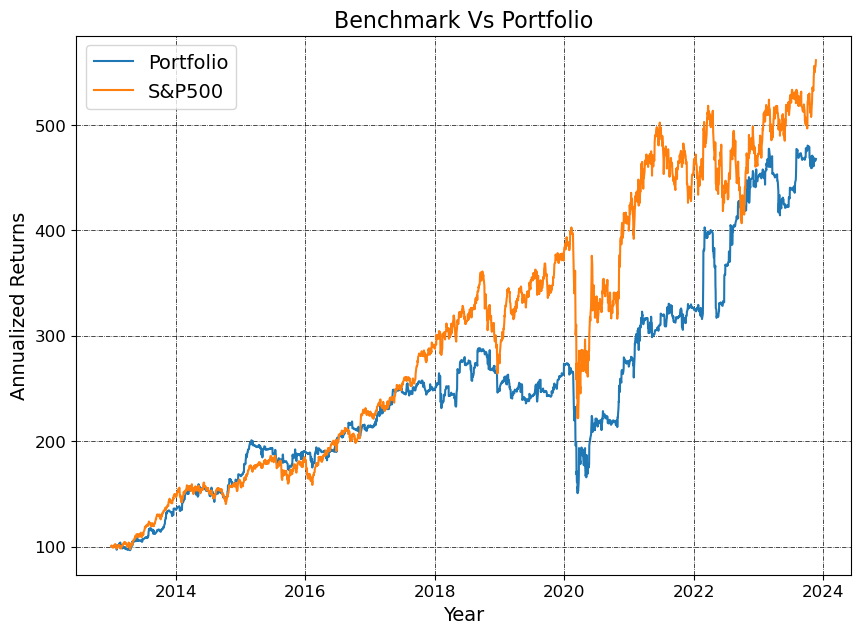

In [29]:
plt.figure(figsize=(10, 7))
cumprod_ret_leverage_2 = (total['FCF Yield & Altman Z & Momentum']*2+1).cumprod()*100
cumprod_market_ret = (total['bm']+1).cumprod()*100
plt.plot(cumprod_ret_leverage_2, label='Portfolio')
plt.plot(cumprod_market_ret, label='Benchmanrk')
plt.title("Benchmark Vs Portfolio", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Annualized Returns", fontsize=14)
plt.legend(["Portfolio", "S&P500"], fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

Long Only

,FCF Yield Factor
2012-01-24,0.008062
2012-02-01,-0.000971
2012-02-03,-0.000289
2012-02-07,0.002946
2012-02-08,-0.000091
...,...
2023-11-02,-0.000315
2023-11-07,-0.002540
2023-11-13,0.001737
2023-11-14,-0.001108


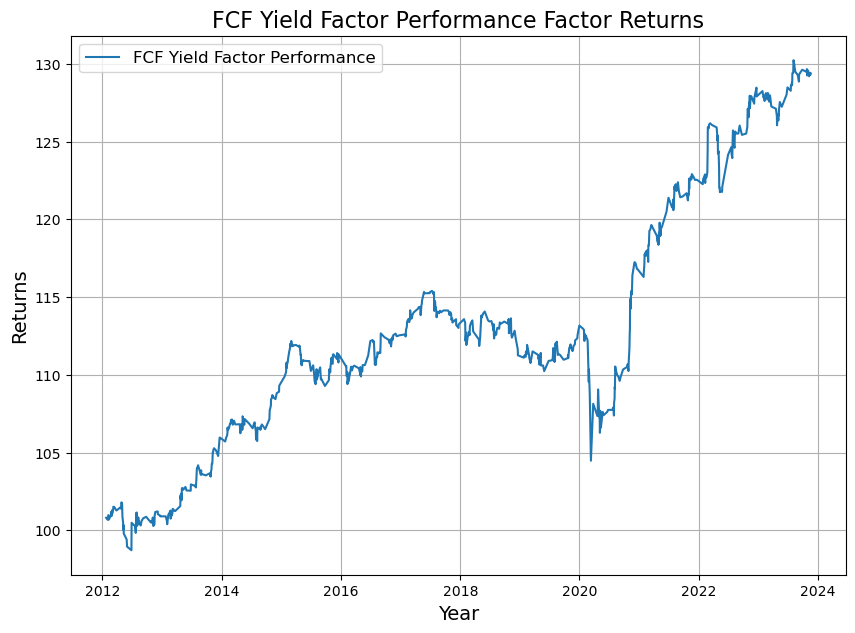

In [30]:
fcf_yield_l = fcf_yield_rank[fcf_yield_rank > int(len(fcf_yield_rank.columns)*.75)]              # long when the fcf yield is in the 60th percentile or higher
fcf_perf_l = (df_change * ~fcf_yield_l.isnull()).mean(axis=1)  # high fcf yield vs short fcf yield
fcf_perf_l = pd.DataFrame(fcf_perf_l.dropna(), columns=['FCF Yield Factor'])                        # creating a dataframe
fcf_perf_l.index = pd.to_datetime(fcf_perf_l.index, format='%Y-%m-%d')                              # changing to datetime index
display(fcf_perf_l)
plt.figure(figsize=(10, 7))
plt.plot((fcf_perf_l + 1).cumprod()* 100, label='FCF Yield Factor Performance')
plt.legend(loc='best', fontsize=12)
plt.title('FCF Yield Factor Performance Factor Returns', fontsize=16)
plt.ylabel('Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

Long Only Momentum

,Momentum Factor
Date,
2023-11-16,0.000349
2023-11-17,0.001570
2023-11-20,0.000197
2023-11-21,0.003188
2023-11-22,0.002369


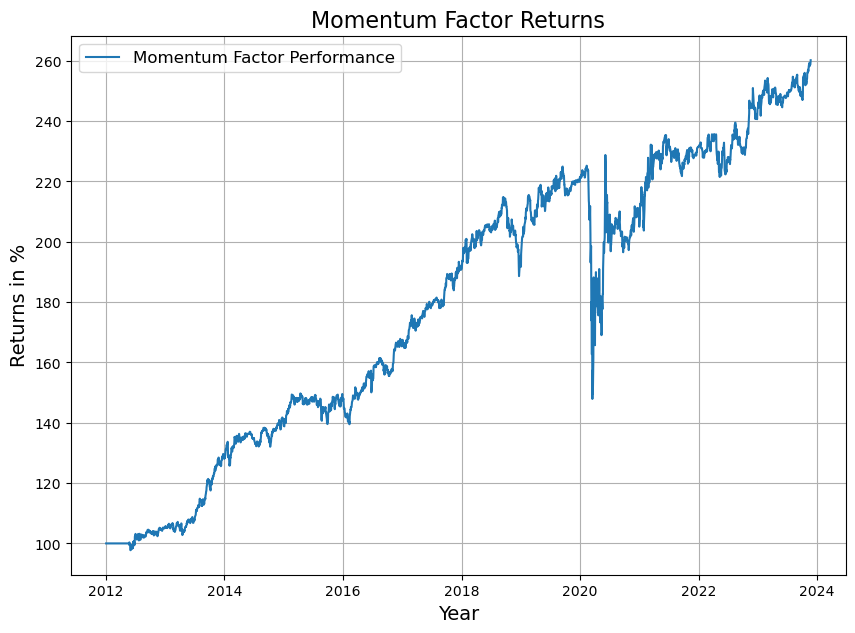

In [31]:
mom_perf_l = (df_change * ~ml.isnull()).mean(axis=1)                                              # difference between positive momentum and negative momentum
mom_perf_l = pd.DataFrame(mom_perf_l.dropna(), columns=['Momentum Factor'])                       # changing to a dataframe 
mom_perf_l.index = pd.to_datetime(mom_perf_l.index, format='%Y-%m-%d')                            # changing to datetime index
display(mom_perf_l.tail())
plt.figure(figsize=(10, 7))
plt.plot((mom_perf_l + 1).cumprod()* 100, label='Momentum Factor Performance')
plt.legend(loc='best', fontsize=12)
plt.title('Momentum Factor Returns', fontsize=16)
plt.ylabel('Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

Altman Long Only

,Altman Z-Score Factor
2012-01-24,-0.003363
2012-02-01,-0.000221
2012-02-03,-0.003185
2012-02-07,0.006560
2012-02-08,-0.002053
...,...
2023-11-02,0.008461
2023-11-07,-0.005300
2023-11-13,0.015286
2023-11-14,-0.002846


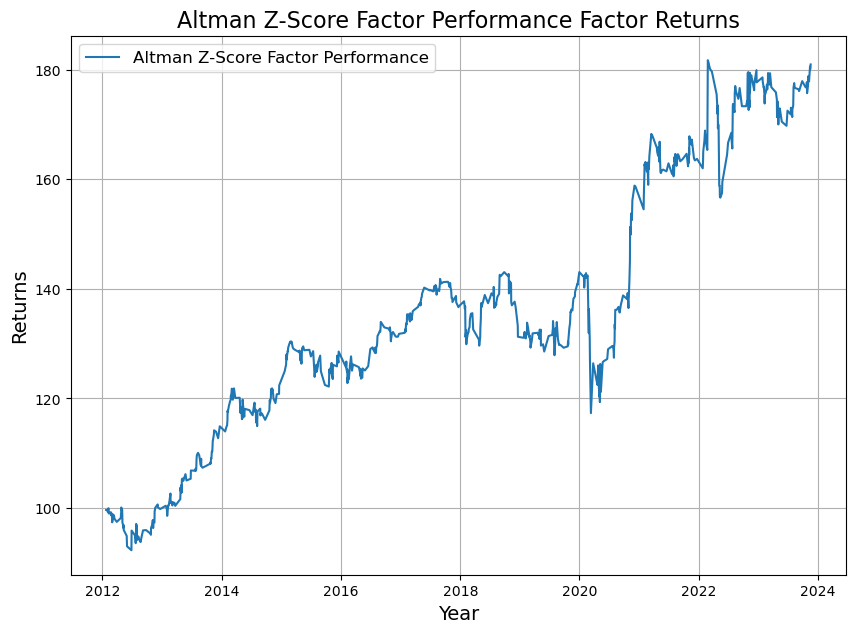

In [32]:
alt_perf_l = (df_change * ~alt_l.isnull()).mean(axis=1)              # high fcf yield vs short fcf yield
alt_perf_l = pd.DataFrame(alt_perf_l.dropna(), columns=['Altman Z-Score Factor'])             # creating a dataframe
alt_perf_l.index = pd.to_datetime(alt_perf_l.index, format='%Y-%m-%d')                              # changing to datetime index
display(alt_perf_l)
plt.figure(figsize=(10, 7))
plt.plot((alt_perf_l + 1).cumprod()* 100, label='Altman Z-Score Factor Performance')
plt.legend(loc='best', fontsize=12)
plt.title('Altman Z-Score Factor Performance Factor Returns', fontsize=16)
plt.ylabel('Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

In [39]:
total_l = pd.concat([fcf_perf_l, mom_perf_l, alt_perf_l],axis=1).fillna(0)
total_l = total_l['2013':]
total_l['FCF Yield & Altman Z & Momentum'] = total_l['Altman Z-Score Factor'] + total_l['FCF Yield Factor'] + total_l['Momentum Factor'] / 3
total_l['FCF Yield & Momentum'] = total_l['FCF Yield Factor'] + total_l['Momentum Factor'] / 2
total_l['Altman & Momentum'] = total_l['Altman Z-Score Factor'] + total_l['Momentum Factor'] / 2
total_l['FCF Yield & Altman'] = total_l['FCF Yield Factor'] + total_l['Altman Z-Score Factor'] / 2
total_l['benchmark'] = bench
total_l

,FCF Yield Factor,Momentum Factor,Altman Z-Score Factor,FCF Yield & Altman Z & Momentum,FCF Yield & Momentum,Altman & Momentum,FCF Yield & Altman,benchmark
2013-01-02,0.000000,0.001308,0.000000,0.000436,0.000654,0.000654,0.000000,0.003528
2013-01-03,0.000000,0.002349,0.000000,0.000783,0.001175,0.001175,0.000000,0.006556
2013-01-04,0.000000,-0.002577,0.000000,-0.000859,-0.001288,-0.001288,0.000000,-0.007166
2013-01-07,0.000000,-0.003634,0.000000,-0.001211,-0.001817,-0.001817,0.000000,-0.009958
2013-01-08,0.000000,0.003293,0.000000,0.001098,0.001646,0.001646,0.000000,0.007163
...,...,...,...,...,...,...,...,...
2023-11-16,0.000000,0.000349,0.000000,0.000116,0.000175,0.000175,0.000000,0.000099
2023-11-17,0.000797,0.001570,0.004971,0.006292,0.001582,0.005756,0.003283,0.007344
2023-11-20,0.000000,0.000197,0.000000,0.000066,0.000098,0.000098,0.000000,0.003050
2023-11-21,0.000000,0.003188,0.000000,0.001063,0.001594,0.001594,0.000000,0.004480


,Annual Returns
FCF Yield Factor,2.36
Momentum Factor,9.63
Altman Z-Score Factor,6.07
FCF Yield & Altman Z & Momentum,11.96
FCF Yield & Momentum,7.18
Altman & Momentum,11.06
FCF Yield & Altman,5.43
benchmark,20.04


<Axes: title={'center': 'Annual Returns'}>

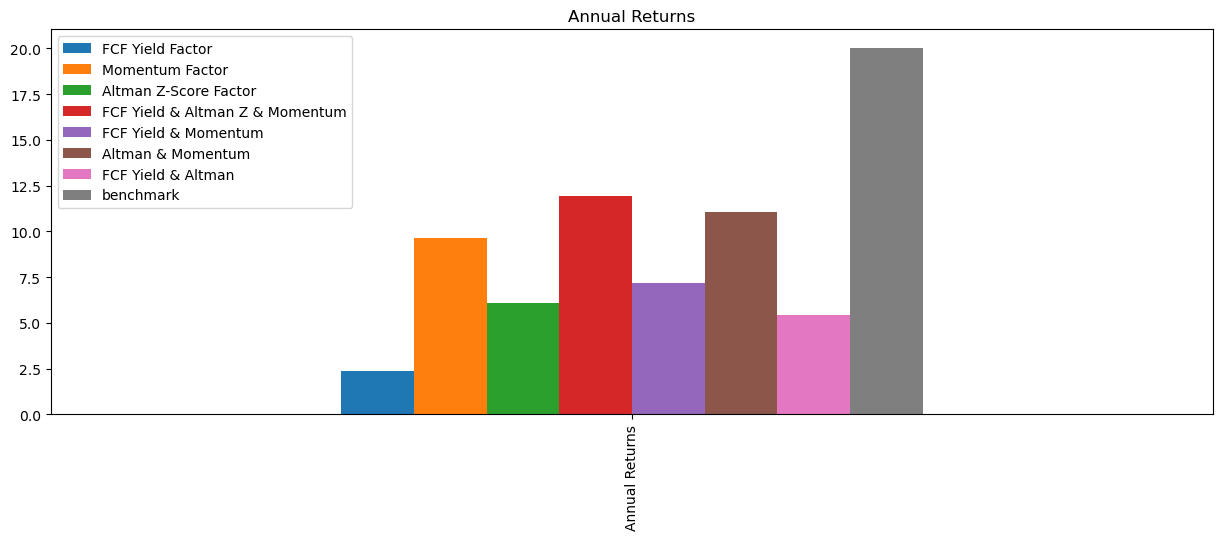

In [40]:
risk_free_rate = 0.02
trading_days = 252
average_daily_returns = total_l.mean()
annual_returns = ((1 + average_daily_returns)**(trading_days) - 1)*100
display(pd.DataFrame(round(annual_returns,2), columns = ['Annual Returns']))
pd.DataFrame(round(annual_returns,2), columns = ['Annual Returns']).T.plot.bar(figsize=(15, 5), title="Annual Returns")

,Annual Volatility
FCF Yield Factor,3.19
Momentum Factor,13.34
Altman Z-Score Factor,9.31
FCF Yield & Altman Z & Momentum,14.68
FCF Yield & Momentum,8.47
Altman & Momentum,13.55
FCF Yield & Altman,7.62
benchmark,21.94


<Axes: title={'center': 'Annual Volatility'}>

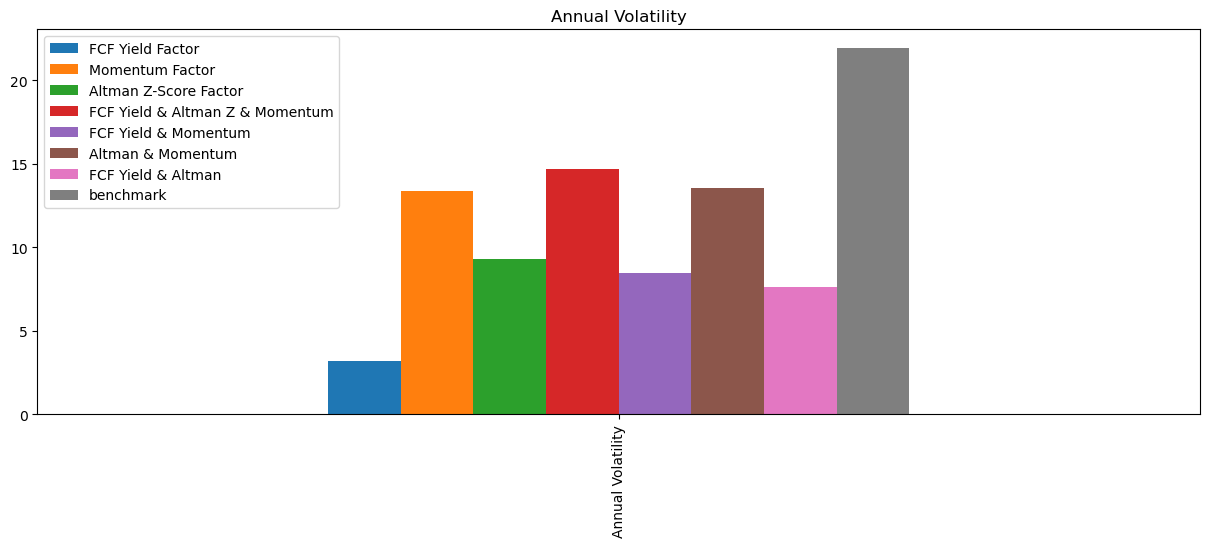

In [41]:
daily_std_dev = total_l.std()
annual_volatility = daily_std_dev * np.sqrt(trading_days) * 100
display(pd.DataFrame(round(annual_volatility,2), columns = ['Annual Volatility']))
pd.DataFrame(round(annual_volatility,2), columns = ['Annual Volatility']).T.plot.bar(figsize=(15, 5), title="Annual Volatility")

,Sharpe Ratio
FCF Yield Factor,0.73
Momentum Factor,0.69
Altman Z-Score Factor,0.63
FCF Yield & Altman Z & Momentum,0.77
FCF Yield & Momentum,0.82
Altman & Momentum,0.77
FCF Yield & Altman,0.69
benchmark,0.83


<Axes: title={'center': 'Sharpe Ratios'}>

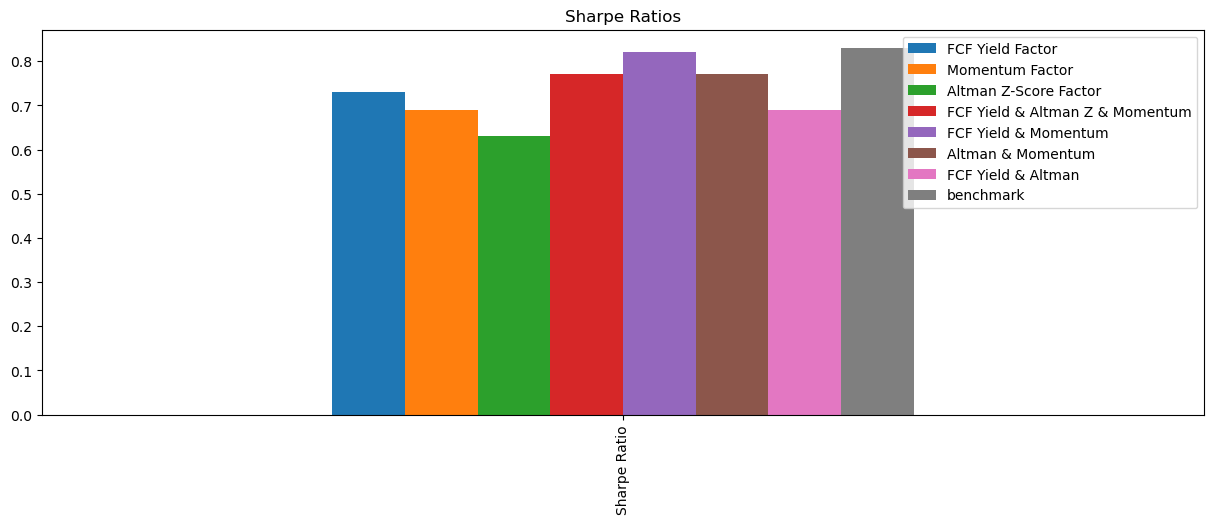

In [42]:
daily_risk_free_return = risk_free_rate/trading_days
excess_daily_returns = total_l - 0.00
sharpe_ratio = (excess_daily_returns.mean() /
                excess_daily_returns.std()) * np.sqrt(trading_days)
display(pd.DataFrame(round(sharpe_ratio,2), columns = ['Sharpe Ratio']))
pd.DataFrame(round(sharpe_ratio,2), columns = ['Sharpe Ratio']).T.plot.bar(figsize=(15, 5), title="Sharpe Ratios")

Sortino Ratio

,Sortino Ratio
FCF Yield Factor,1.08
Momentum Factor,0.97
Altman Z-Score Factor,0.93
FCF Yield & Altman Z & Momentum,1.11
FCF Yield & Momentum,1.16
Altman & Momentum,1.11
FCF Yield & Altman,1.02
benchmark,1.15


<Axes: title={'center': 'Sortino Ratios'}>

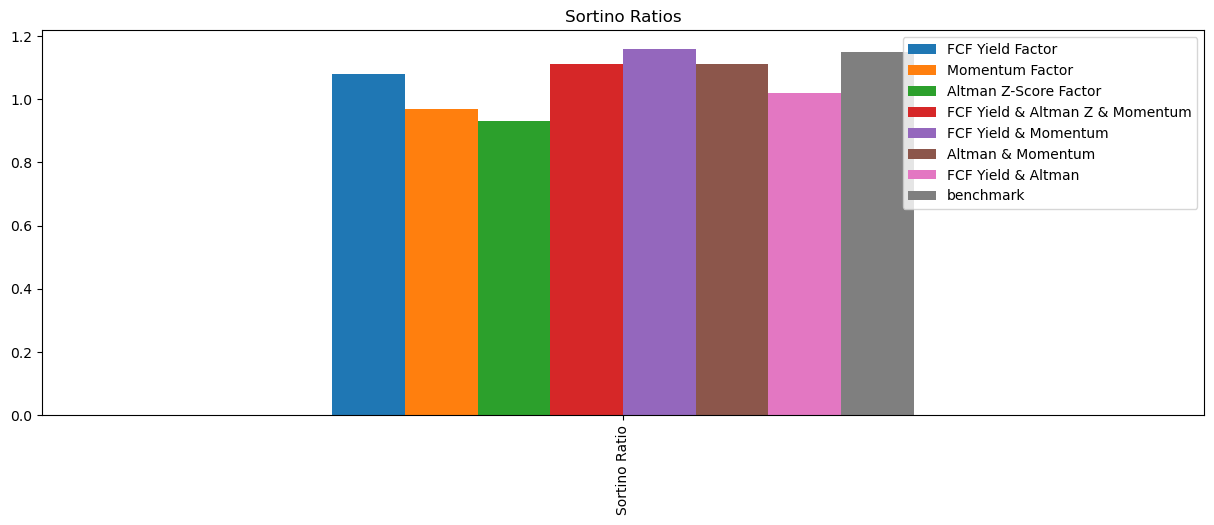

In [43]:
net_returns = total_l - average_daily_returns
negative_returns = net_returns[net_returns < 0]
semi_dev = np.sqrt(np.sum((negative_returns**2))/len(total))
sortino_ratio = (excess_daily_returns.mean()/semi_dev) * np.sqrt(trading_days)
display(pd.DataFrame(round(sortino_ratio,2), columns = ['Sortino Ratio']).dropna())
pd.DataFrame(round(sortino_ratio,2), columns = ['Sortino Ratio']).dropna().T.plot.bar(figsize=(15, 5), title="Sortino Ratios")

Beta

In [44]:
bm = df.pivot_table(columns = 'ticker',values = 'Adj Close',index = 'Date')[['SPY']].pct_change().shift(-1)
bm.index = pd.to_datetime(bm.index)
total_l['SPY'] = bm
for i in total_l.columns:
    covariance_matrix = total_l[['SPY', i]].cov()
    covariance_value = covariance_matrix.iloc[0][i]
    market_variance = total_l['SPY'].var()
    beta = covariance_value/market_variance
    print(f'Beta {i}: {round(beta,2)}')

Beta FCF Yield Factor: 0.07
Beta Momentum Factor: 0.54
Beta Altman Z-Score Factor: 0.21
Beta FCF Yield & Altman Z & Momentum: 0.46
Beta FCF Yield & Momentum: 0.34
Beta Altman & Momentum: 0.49
Beta FCF Yield & Altman: 0.17
Beta benchmark: 1.02
Beta SPY: SPY    1.0
SPY    1.0
Name: SPY, dtype: float64


Monthly Hit Rate

,FCF Yield Factor,Momentum Factor,Altman Z-Score Factor,FCF Yield & Altman Z & Momentum,FCF Yield & Momentum,Altman & Momentum,FCF Yield & Altman,benchmark,SPY
2013-01-31,-0.002832,0.004812,-0.000025,-0.001260,-0.000435,0.002379,-0.002845,-0.006685,0.035623
2013-02-28,0.003307,-0.016746,0.012809,0.010459,-0.005126,0.004301,0.009713,0.006800,0.006354
2013-03-31,0.002960,0.014535,-0.006584,0.001164,0.010223,0.000614,-0.000347,0.019746,0.030705
2013-04-30,0.006894,-0.014283,0.024239,0.026367,-0.000319,0.016907,0.019023,-0.000272,0.015173
2013-05-31,0.006219,0.035192,0.021893,0.040156,0.023773,0.039707,0.017173,0.097216,0.038786
...,...,...,...,...,...,...,...,...,...
2023-07-31,0.007137,0.013334,0.001303,0.012910,0.013828,0.007957,0.007792,0.007219,0.028851
2023-08-31,-0.000960,0.010367,0.021774,0.024307,0.004206,0.027053,0.009861,0.000095,-0.010934
2023-09-30,0.002688,-0.029954,0.008187,0.000711,-0.012435,-0.007015,0.006784,-0.054261,-0.049163
2023-10-31,-0.002818,0.026733,-0.012256,-0.006332,0.010428,0.000871,-0.008948,0.039879,-0.010010


,Monthly Hit Rate
Altman Z-Score Factor,0.53
FCF Yield & Altman,0.54
FCF Yield Factor,0.57
FCF Yield & Altman Z & Momentum,0.58
Altman & Momentum,0.60
FCF Yield & Momentum,0.61
Momentum Factor,0.62
benchmark,0.63
SPY,0.69


<Axes: title={'center': 'Monthly Hit Rate'}>

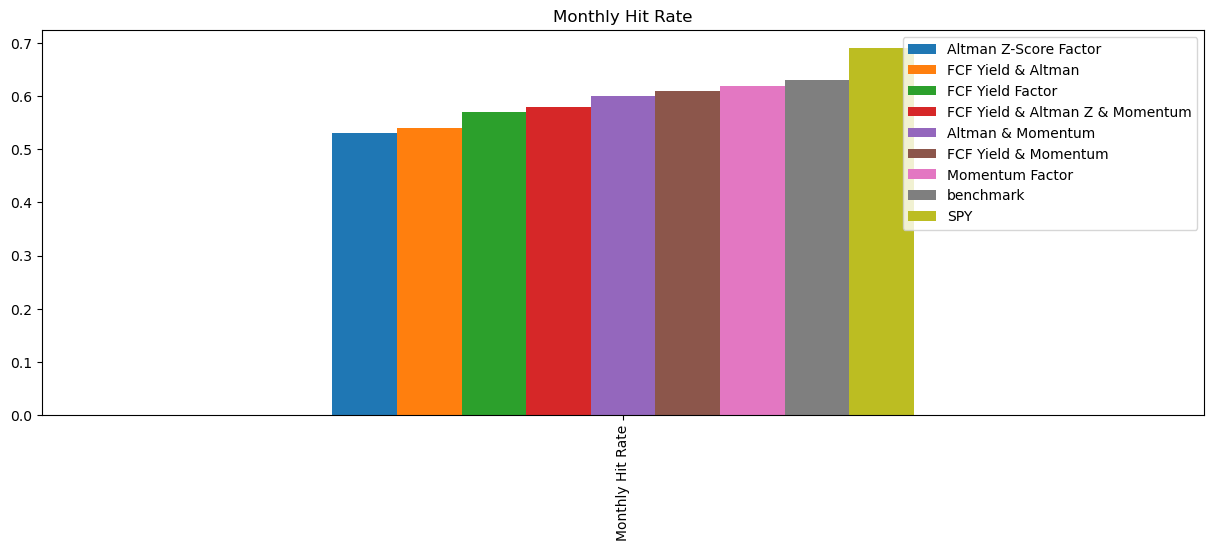

In [45]:
portfolio_monthly_mean = total_l.resample('M').mean()
portfolio_monthly_count = total_l.resample('M').count()
portfolio_monthly_ret = (portfolio_monthly_mean +
                         1)**(portfolio_monthly_count) - 1
target = 0.00
display(portfolio_monthly_ret)
portfolio_monthly_ret[portfolio_monthly_ret >= target] = 1
portfolio_monthly_ret[portfolio_monthly_ret < target] = 0
display(pd.DataFrame(round(portfolio_monthly_ret.mean(),2).sort_values(), columns = ['Monthly Hit Rate']))
pd.DataFrame(round(portfolio_monthly_ret.mean(),2).sort_values(), columns = ['Monthly Hit Rate']).T.plot.bar(figsize=(15, 5), title="Monthly Hit Rate")

,Max Drawdown
benchmark,-0.45
FCF Yield & Altman Z & Momentum,-0.34
Momentum Factor,-0.34
SPY,-0.34
Altman & Momentum,-0.34
FCF Yield & Momentum,-0.25
Altman Z-Score Factor,-0.18
FCF Yield & Altman,-0.17
FCF Yield Factor,-0.09


<Axes: title={'center': 'Max Drawdown'}>

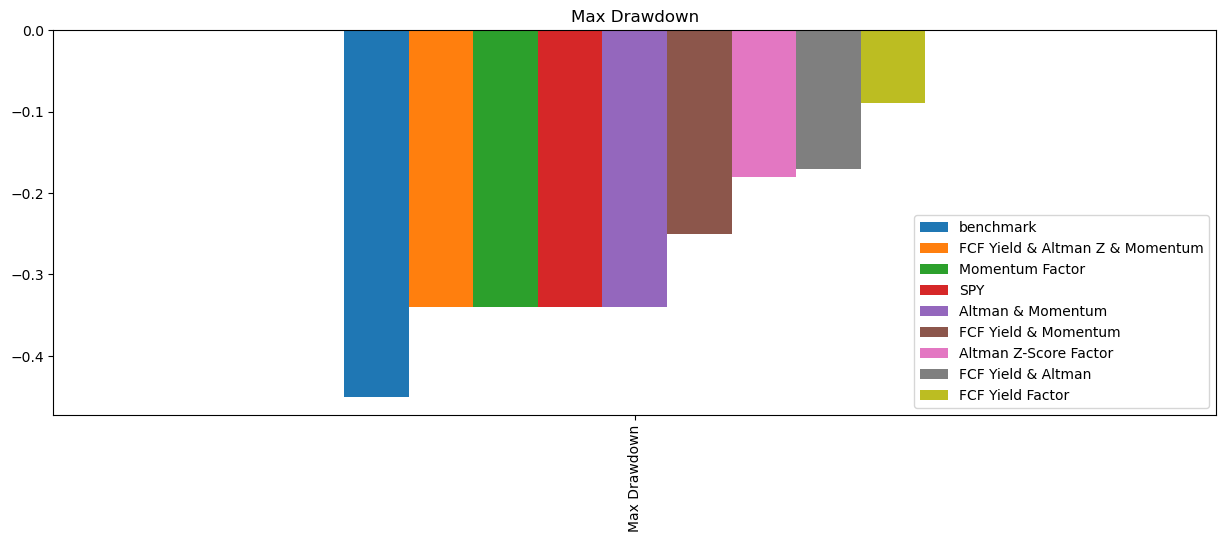

In [50]:
cumprod_ret = (total_l+1).cumprod()*100
cumprod_market_ret = (total_l['SPY']+1).cumprod()*100
cumprod_ret.index = pd.to_datetime(cumprod_ret.index)
running_max = np.maximum.accumulate(cumprod_ret.dropna())
running_max[running_max < 1] = 1
drawdown = ((cumprod_ret)/running_max - 1)
display(pd.DataFrame(round(drawdown.min().sort_values(),2),columns = ['Max Drawdown']))
pd.DataFrame(round(drawdown.min().sort_values(),2),columns = ['Max Drawdown']).T.plot.bar(figsize=(15, 5), title="Max Drawdown")

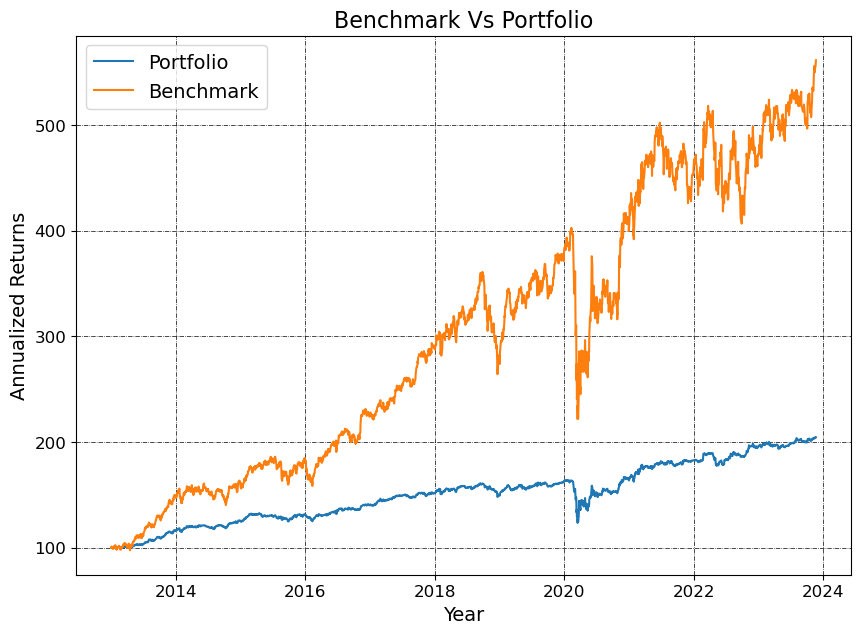

In [47]:
plt.figure(figsize=(10, 7))
cumprod_ret_leverage_2 = (total_l['FCF Yield & Momentum']+1).cumprod()*100
cumprod_market_ret = (total_l['benchmark']+1).cumprod()*100
plt.plot(cumprod_ret_leverage_2, label='Portfolio')
plt.plot(cumprod_market_ret, label='Benchmanrk')
plt.title("Benchmark Vs Portfolio", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Annualized Returns", fontsize=14)
plt.legend(["Portfolio", "Benchmark"], fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [70]:
pd.DataFrame(alt.iloc[-1].rank()).sort_values('2023-11-17',ascending=False)

,2023-11-17
symbol,
RGR,24.0
NPK,23.0
SWBI,22.0
AVAV,21.0
HXL,20.0
AIR,19.0
CW,18.0
HEI,17.0
MOG-A,16.0


In [67]:
pd.DataFrame(fcf_yield.iloc[-1].rank()).sort_values('2023-11-17',ascending=False)

,2023-11-17
symbol,
HII,24.0
MOG-A,23.0
LMT,22.0
RTX,21.0
CW,20.0
WWD,19.0
GD,18.0
SWBI,17.0
NOC,16.0


,2023-11-17
symbol,
HII,2.99
CW,1.69
HXL,0.86
LHX,0.91
LMT,2.27


<Axes: title={'center': 'FCF Yield'}, xlabel='symbol'>

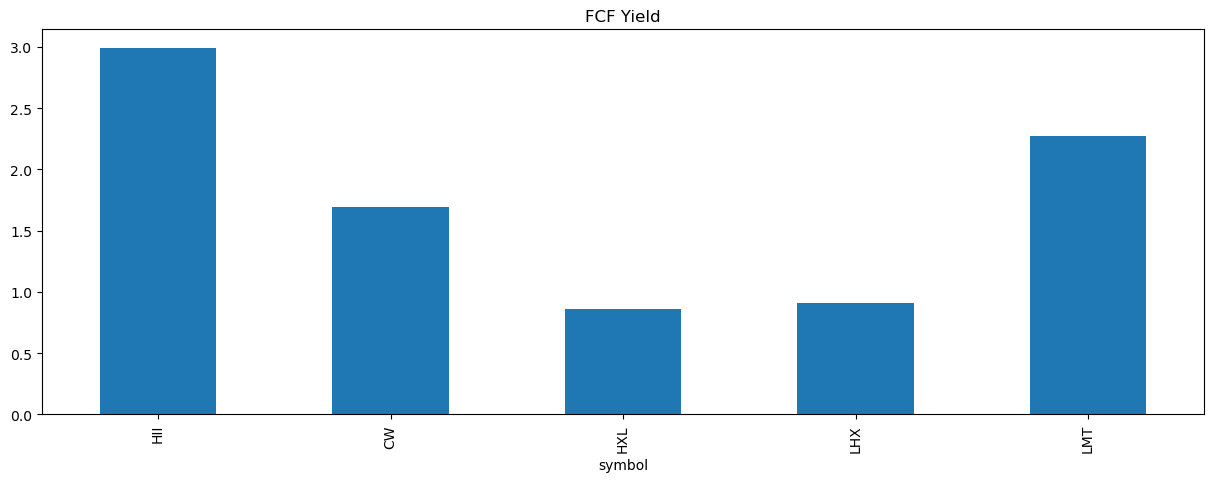

In [54]:
fcf_y_plot = fcf_yield[["HII", "CW", "HXL","LHX","LMT"]].iloc[-1]*100
display(pd.DataFrame(round(fcf_y_plot,2)))
display(fcf_y_plot.plot.bar(figsize=(15, 5), title="FCF Yield"))

,2023-11-17
symbol,
HII,1.22
CW,2.13
HXL,2.32
LHX,0.98
LMT,1.07


<Axes: title={'center': 'Altman Z-Score'}, xlabel='symbol'>

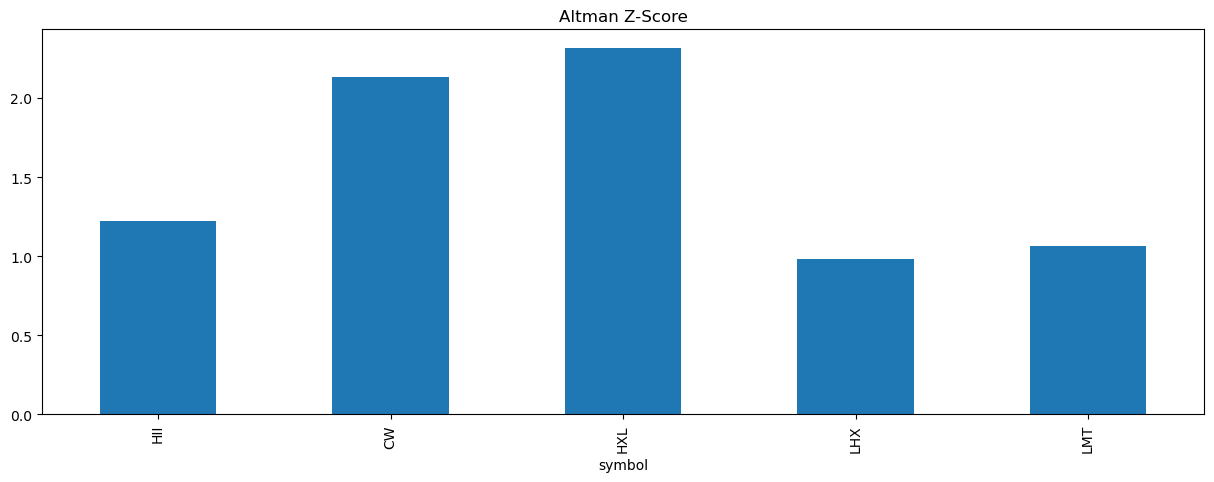

In [58]:
# alt[["HII", "CW", "HXL","LHX","LMT"]].iloc[-1]
alt_y_plot = alt[["HII", "CW", "HXL","LHX","LMT"]].iloc[-1]
display(pd.DataFrame(round(alt_y_plot,2)))
display(alt_y_plot.plot.bar(figsize=(15, 5), title="Altman Z-Score"))

In [69]:
mf.iloc[-1].rank()

ticker
AIR      11.0
AVAV     16.0
AXON      3.0
BA       12.0
BWXT      7.0
CW        6.0
GD       14.0
HEI       9.0
HII      17.0
HXL      22.0
KAMN     18.0
LHX      23.0
LMT      21.0
MOG-A    20.0
MRCY      2.0
NOC      10.0
NPK       8.0
RGR       5.0
RTX      24.0
SWBI     19.0
TDG      13.0
TGI      15.0
TXT       4.0
WWD       1.0
Name: 2023-11-24 00:00:00, dtype: float64

,2023-11-24
ticker,
HII,0.57
CW,0.48
HXL,0.60
LHX,0.63
LMT,0.60


<Axes: title={'center': 'Hurst Exponent (Momentum Factor'}, xlabel='ticker'>

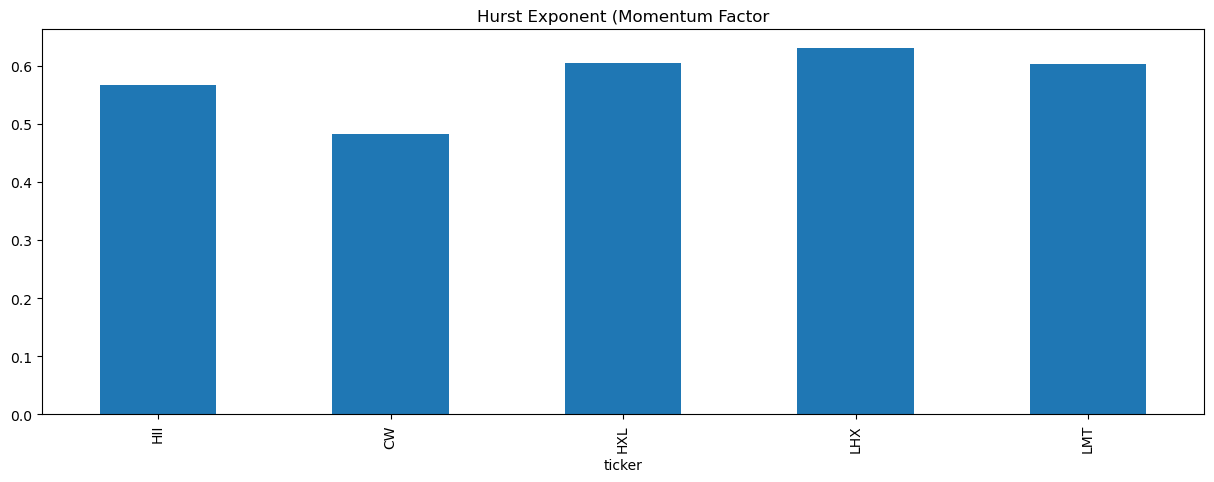

In [59]:
mf_y_plot = mf[["HII", "CW", "HXL","LHX","LMT"]].iloc[-1]
display(pd.DataFrame(round(mf_y_plot,2)))
display(mf_y_plot.plot.bar(figsize=(15, 5), title="Hurst Exponent (Momentum Factor"))

In [84]:
alt[["HII", "CW", "MOG-A","HXL","LHX","LMT"]]

symbol,HII,CW,MOG-A,HXL,LHX,LMT
fillingDate,,,,,,
2011-05-11,0.668219,1.835024,1.559279,1.636480,1.481950,0.979922
2011-05-13,0.668219,1.835024,1.559279,1.636480,1.481950,0.979922
2011-05-18,0.668219,1.835024,1.559279,1.636480,1.481950,0.979922
2011-05-31,0.668219,1.835024,1.559279,1.636480,1.481950,0.979922
2011-06-22,0.668219,1.835024,1.559279,1.636480,1.481950,0.979922
...,...,...,...,...,...,...
2023-11-02,1.224468,2.131317,1.954159,2.317933,0.979415,1.065226
2023-11-07,1.224468,2.131317,1.954159,2.317933,0.979415,1.065226
2023-11-13,1.224468,2.131317,1.954159,2.317933,0.979415,1.065226


In [102]:
surprise = f'https://financialmodelingprep.com/api/v3/earnings-surprises/HII?apikey={API_KEY}'
response = requests.get(surprise)
ear_sur = response.json()
earnings_surprise = pd.DataFrame(ear_sur)
earnings_surprise['Surprise'] = (earnings_surprise['actualEarningResult'] - earnings_surprise['estimatedEarning']) / earnings_surprise['estimatedEarning']
earnings_surprise

,date,symbol,actualEarningResult,estimatedEarning,Surprise
0,2023-11-02,HII,3.70,3.39,0.091445
1,2023-08-03,HII,3.27,3.12,0.048077
2,2023-05-04,HII,3.23,2.90,0.113793
3,2023-02-09,HII,3.07,3.29,-0.066869
4,2022-11-03,HII,3.44,3.42,0.005848
5,2022-08-04,HII,4.44,3.35,0.325373
6,2022-05-05,HII,3.50,3.19,0.097179
7,2022-02-10,HII,2.99,2.97,0.006734
8,2021-11-04,HII,3.65,2.99,0.220736
9,2021-08-05,HII,3.20,2.51,0.274900


In [105]:
surprise = f'https://financialmodelingprep.com/api/v3/earnings-surprises/MOG-A?apikey={API_KEY}'
response = requests.get(surprise)
ear_sur = response.json()
earnings_surprise = pd.DataFrame(ear_sur)
earnings_surprise['Surprise'] = (earnings_surprise['actualEarningResult'] - earnings_surprise['estimatedEarning']) / earnings_surprise['estimatedEarning']
earnings_surprise.head(30)

,date,symbol,actualEarningResult,estimatedEarning,Surprise
0,2023-11-03,MOG-A,2.10,1.71,0.228070
1,2023-07-28,MOG-A,1.37,1.47,-0.068027
2,2023-04-28,MOG-A,1.42,1.43,-0.006993
3,2023-02-03,MOG-A,1.25,1.28,-0.023438
4,2022-11-04,MOG-A,1.36,1.45,-0.062069
5,2022-07-29,MOG-A,1.61,1.41,0.141844
6,2022-04-29,MOG-A,1.49,1.28,0.164062
7,2022-01-28,MOG-A,1.11,1.18,-0.059322
8,2021-11-05,MOG-A,1.07,1.20,-0.108333
9,2021-07-30,MOG-A,1.12,1.20,-0.066667


In [107]:
surprise = f'https://financialmodelingprep.com/api/v3/earnings-surprises/LMT?apikey={API_KEY}'
response = requests.get(surprise)
ear_sur = response.json()
earnings_surprise = pd.DataFrame(ear_sur)
earnings_surprise['Surprise'] = (earnings_surprise['actualEarningResult'] - earnings_surprise['estimatedEarning']) / earnings_surprise['estimatedEarning']
earnings_surprise.head(30)

,date,symbol,actualEarningResult,estimatedEarning,Surprise
0,2023-10-17,LMT,6.73,6.67,0.008996
1,2023-07-18,LMT,6.63,6.45,0.027907
2,2023-04-18,LMT,6.61,6.06,0.090759
3,2023-01-24,LMT,7.40,7.39,0.001353
4,2022-10-18,LMT,6.71,6.66,0.007508
5,2022-07-19,LMT,1.99,1.74,0.143678
6,2022-04-19,LMT,6.44,6.21,0.037037
7,2022-01-25,LMT,7.47,7.16,0.043296
8,2021-10-26,LMT,6.66,1.96,2.397959
9,2021-07-26,LMT,7.13,6.53,0.091884
